In [1]:
import pandas as pd

In [2]:
def clean_and_drop(df):
    # 只篩選有包含 '住' 用途的交易案
    df = df.loc[df['Main_Usage_Living'] == 1]
    df = df.drop(columns=['Main_Usage_Living'])

    # 因為都是 0
    df = df.drop(columns=['Non_City_Land_Usage', 'Main_Usage_Walk',
                          'Main_Usage_Selling',
                          'Main_Usage_SnE'])

    # 只有 344 筆是包含工廠用途，且都不具住宅用途，故剔除
    df = df.loc[df['Main_Usage_Manufacturing'] == 0]
    df = df.drop(columns=['Main_Usage_Manufacturing'])

    # 只有 76 筆是包含停車用途，且都不具住宅用途，故剔除
    df = df.loc[df['Main_Usage_Parking'] == 0]
    df = df.drop(columns=['Main_Usage_Parking'])

    # 只有 78 筆有農業用途，且都不具住宅用途，故剔除
    df = df.loc[df['Main_Usage_Farm'] == 0]
    df = df.drop(columns=['Main_Usage_Farm'])

    # NOTICE: 我沒有錢，所以我先只買 6 房以下的
    df = df.loc[df['room'] < 6]

    df = df.loc[df['trading_floors_count'] == 1]

    # 雖然有 95 個樣本包含地下室，但是樣本太少，可能不足以推廣
    # 所以先剔除，剔除完後，都是 0 所以直接 drop
    df = df.loc[df['including_basement'] == 0]
    df = df.drop(columns=['including_basement'])

    # 所有的樣本都不包含人行道，所以直接去除這個 feature
    df = df.drop(columns=['including_arcade'])

    # 剔除交易樓層高度是 -1 (原本有一個樣本)
    df = df.loc[df['min_floors_height'] != -1]

    # 剔除交易建物是 0 個樓層的情況
    df = df.loc[df['building_total_floors'] != 0]

    # 因為車位交易 50 坪以上的資料只有 22 筆，所以先去除
    # 因為浮點數在硬體儲存會有小數點，故不能直接用 == 50.0 去比較
    df = df.loc[df['Parking_Area'] < 49.5]

    # 把農舍，廠辦踢掉
    df = df.loc[df['Building_Types'] < 8]

    # 把超大轉移坪數刪掉
    df = df.loc[df['Transfer_Total_Ping'] < 150]

    # Transaction_Land == 0 只有 5 筆
    df = df.loc[df['Transaction_Land'] != 0]

    # 只取交易一個建物的案子
    df = df.loc[df['Transaction_Building'] == 1]

    # 交易車位數 > 3 只有 98 個案例，比較少，故去除
    df = df.loc[df['Transaction_Parking'] <= 3]

    # 目前不特別區分備註欄位是不是空的，因為用 one-hot encoding
    # 處理了，所以 Note_<tag> 不是全部都是 0 就代表有備註的項目
    df = df.drop(columns=['Note_Null'])

    # 去除政府承購, 去除後在 future data 中皆為 0
    df = df.loc[df['Note_Gov'] == 0]
    df = df.drop(columns=['Note_Gov'])

    # Only 85 cases in the dataset
    df = df.drop(columns=['Note_Layer'])

    # 毛胚屋，去除後皆為 0
    df = df.loc[df['Note_BlankHouse'] == 0]
    df = df.drop(columns=['Note_BlankHouse'])

    # 債權相關，只有 3 個，去除後皆為 0
    df = df.loc[df['Note_Debt'] == 0]
    df = df.drop(columns=['Note_Debt'])

    # 備註中有提到有電梯的只有 2 筆
    df = df.loc[df['Note_Elevator'] == 0]
    df = df.drop(columns=['Note_Elevator'])

    # Note_Shop, 只有 110 筆
    df = df.loc[df['Note_Shop'] == 0]
    df = df.drop(columns=['Note_Shop'])

    # All 0
    df = df.drop(columns=['Note_Additions', 'Note_Balcony',
                          'Note_PublicUtilities', 'Note_PartRegister',
                          'Note_Negotiate', 'Note_OnlyParking',
                          'Note_Overbuild', 'Note_BuildWithLandholder',
                          'Note_Defect', 'Note_Renewal', 'Note_DistressSale ',
                          'Note_OverdueInherit', 'Note_DeformedLand'])

    # **Notice**
    # 因為 future price data 應該是預設屋的資料，所以每一欄位的 presold 應該都要是 1
    # 但是有其他是 0, 所以直接刪掉這個欄位
    df = df.drop(columns=['Note_Presold'])

    # 只取跟親友無關的交易
    df = df.loc[df['Note_Relationships'] == 0]

    # 我先刪除 area_m2, 因為覺得跟 area_ping 的意義很類似，但是不確定會不會有些微差距。
    # 因為在 future data 中，manager 都是 0，所以也把這個欄位刪除
    # trading_floor_count 有 0 的情況，這樣應該不是房屋交易
    df = df.drop(columns=['address', 'area_m2', 'manager', 'Building_Material_stone',
                          'TDATE', 'Total_price', '編號'])

    # Convert the categorical features' dtype to 'category'
    category_columns = ['Type', 'Month', 'Month_raw',
                        'room', 'City_Land_Usage', 'Main_Usage_Business',
                        'Building_Material_S', 'Building_Material_R', 'Building_Material_C',
                        'Building_Material_steel', 'Building_Material_B',
                        'Building_Material_W', 'Building_Material_iron',
                        'Building_Material_tile', 'Building_Material_clay',
                        'Building_Material_RC_reinforce',
                        'Parking_Space_Types', 'Building_Types']
    df.loc[:, category_columns] = df.loc[:,
                                         category_columns].astype('category')
    return df

In [3]:
df = pd.read_csv('../merged_data/clean_data_future_train.csv')

In [4]:
df.loc[df['Month'] > 202111, 'val'] = 0
df.loc[df['Month'] <= 202110, 'val'] = 1
df['val'] = df['val'].astype('bool_')
df = clean_and_drop(df)

In [5]:
df = df.sample(frac=1)

In [6]:
from sklearn.linear_model import LogisticRegression

X = df.drop(columns=['val'])
y = df['val']
model = LogisticRegression(penalty='l2')
model.fit(X, y)

LogisticRegression()

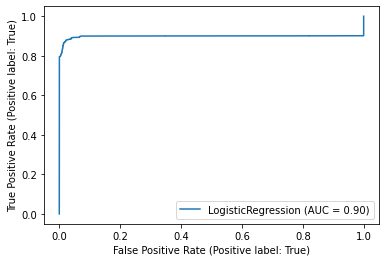

In [7]:
%matplotlib inline
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(model, X, y)